In [1]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
os.environ["SM_FRAMEWORK"] = "tf.keras"
from patchify import patchify
import matplotlib.pyplot as plt
from PIL import Image,ImageOps

from tensorflow import keras
# from tensorflow.keras.utils import get_custom_objects

from IPython.display import display

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

## **Module1**

### **1.1 数据加载**

#### **1.1.1 tiff格式数据**

In [2]:
import rasterio

In [3]:
data_dir = 'module1/tiff'
patch_size = 256

In [4]:
def data_load(data_dir):
  data1 = []
  data2 = []
  for path, subdirs, files in os.walk(data_dir):
      dirname = path.split(os.path.sep)[-1]
      if dirname == 'images':
        images = os.listdir(path)
        for i,image_name in enumerate(sorted(images)):
          if image_name.endswith('.tiff'):
            with rasterio.open(os.path.join(path,image_name)) as src:
              image = src.read([1,2,3])
              image = np.transpose(image,(1,2,0))
              SIZE_X = (image.shape[1] // patch_size) * patch_size
              SIZE_Y = (image.shape[0] // patch_size) * patch_size
              image = Image.fromarray(image)
              image = image.crop((0,0,SIZE_X,SIZE_Y))
              image = np.array(image)
              data1.append(image)
      elif dirname == 'masks':
        images = os.listdir(path)
        for i,image_name in enumerate(sorted(images)):
          if image_name.endswith('.tiff'):
            image = Image.open(os.path.join(path,image_name))
            image = np.array(image)
            SIZE_X = (image.shape[1] // patch_size) * patch_size
            SIZE_Y = (image.shape[0] // patch_size) * patch_size
            image = Image.fromarray(image)
            image = image.crop((0,0,SIZE_X,SIZE_Y))
            image = np.array(image)
            data2.append(image)
  return data1,data2

In [5]:
image_data,mask_data = data_load(data_dir)
mask_data[0].shape

/home/ubuntu/dgw/myenv/lib/python3.6/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(512, 768, 3)

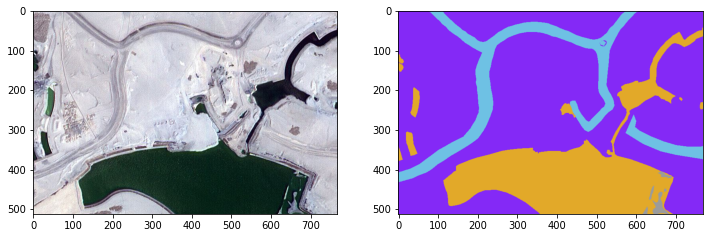

In [6]:
import numpy as np
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_data[1])
plt.subplot(122)
plt.imshow(mask_data[1])
plt.show()

#### **1.1.2 jpg格式数据**

In [7]:
data_dir = 'module1/jpg'
patch_size = 256

In [8]:
def data_load(data_dir):
  data1 = []
  data2 = []
  for path, subdirs, files in os.walk(data_dir):
      dirname = path.split(os.path.sep)[-1]
      if dirname == 'images':
        images = os.listdir(path)
        for i,image_name in enumerate(sorted(images)):
          if image_name.endswith('.jpg'):
            image = cv2.imread(os.path.join(path,image_name),1)
            SIZE_X = (image.shape[1] // patch_size) * patch_size
            SIZE_Y = (image.shape[0] // patch_size) * patch_size
            image = Image.fromarray(image)
            image = image.crop((0,0,SIZE_X,SIZE_Y))
            image = np.array(image)
            data1.append(image)
      elif dirname == 'masks':
        images = os.listdir(path)
        for i,image_name in enumerate(sorted(images)):
          if image_name.endswith('.png'):
            image = cv2.imread(os.path.join(path,image_name),1)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            SIZE_X = (image.shape[1] // patch_size) * patch_size
            SIZE_Y = (image.shape[0] // patch_size) * patch_size
            image = Image.fromarray(image)
            image = image.crop((0,0,SIZE_X,SIZE_Y))
            image = np.array(image)
            data2.append(image)
  return data1,data2

In [9]:
image_data,mask_data = data_load(data_dir)
mask_data[0].shape

(768, 1024, 3)

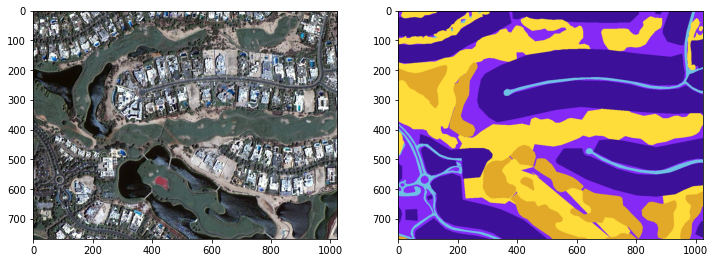

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_data[2])
plt.subplot(122)
plt.imshow(mask_data[2])
plt.show()

### **1.2 分析校正**

#### **1.2.1 去除图像logo**

In [11]:
def remove_logo(images):
  data = []
  for image in images:

    # 获取图像的高度和宽度
    height = image.shape[0]
    width = image.shape[1]

    x1 = width - 100  # 矩形左上角的x坐标
    y1 = height - 50  # 矩形左上角的y坐标
    x2 = width  # 矩形右下角的x坐标
    y2 = height  # 矩形右下角的y坐标
    logo_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.rectangle(logo_mask, (x1, y1), (x2, y2), 255, -1)

    # 使用inpaint函数修复图像
    inpainted_image = cv2.inpaint(image, logo_mask, 3, cv2.INPAINT_TELEA)
    data.append(inpainted_image)
  return data

In [12]:
# 定位图像中的logo未知，去除logo
remove_logo_data = remove_logo(image_data)

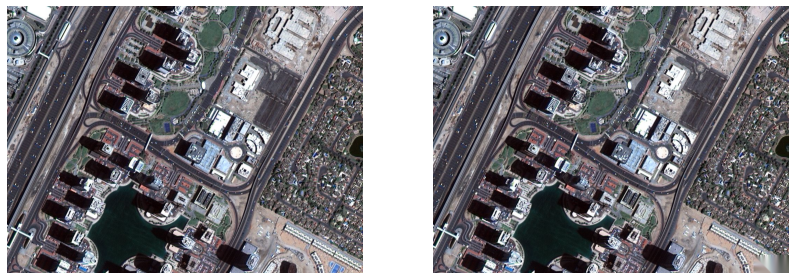

In [13]:
fig,axs = plt.subplots(1,2,figsize=(14,12))
axs[0].imshow(image_data[0])
axs[0].axis('off')
axs[1].imshow(remove_logo_data[0])
axs[1].axis('off')
plt.show()

#### **1.2.2 图像均衡化**

In [14]:
# 对数据进行均衡化处理
def image_processing1(images):
  # 存储出后的的图像数据
  data = []
  # 遍历图像
  for image in images:
    # 分离图像到不同的颜色通道
    channels = cv2.split(image)
    # 对每个通道进行直方图均衡化
    eq_channels = []
    for ch in channels:
      eq_ch = cv2.equalizeHist(ch)
      eq_channels.append(eq_ch)
    # 合并均衡化的通道
    eq_img = cv2.merge(eq_channels)
    data.append(eq_img)
  return data

In [15]:
# 对数据进行均衡化处理
# processing_data1 = image_processing1(images_data)
processing_data1 = image_processing1(remove_logo_data)

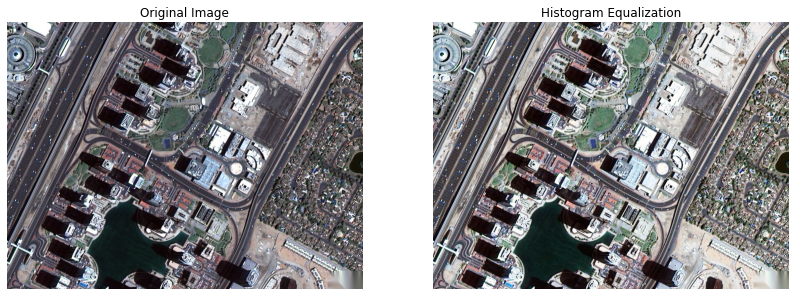

In [16]:
# 对第一张图像的原图 和 均衡化后的图像进行展示
fig,axs = plt.subplots(1,2,figsize=(14,12))
axs[0].imshow(remove_logo_data[0])
axs[0].axis('off')
axs[0].set_title("Original Image")
axs[1].imshow(processing_data1[0])
axs[1].axis('off')
axs[1].set_title("Histogram Equalization")
plt.show()

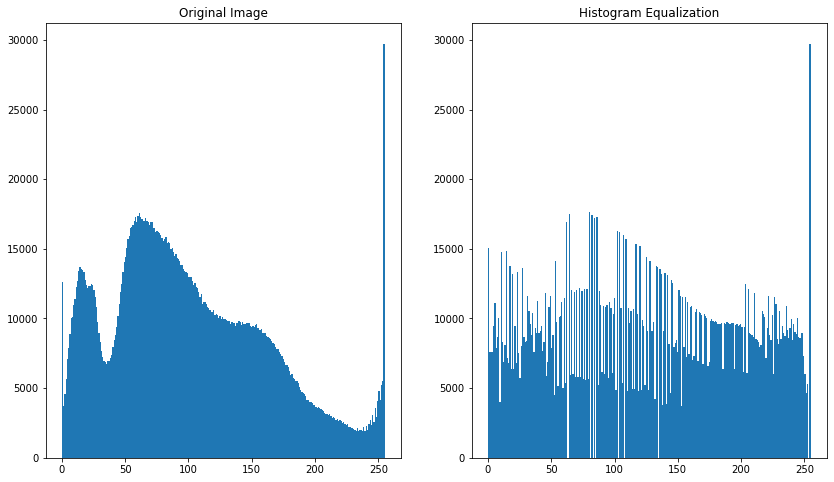

In [17]:
# 对第一张图片的直方图 和 均衡化后的图像直方图进行展示
fig,axs = plt.subplots(1,2,figsize=(14,8))
axs[0].set_title("Original Image")
axs[0].hist(remove_logo_data[0].ravel(),256)
axs[1].set_title("Histogram Equalization")
axs[1].hist(processing_data1[0].ravel(),256)
plt.show()

#### **1.2.3 双边滤波**

In [18]:
# 对图像进行双边滤波
def image_processing2(images):
  data = []
  # 遍历图像
  for image in images:
    bilateral = cv2.bilateralFilter(image,10,20,20)
    data.append(bilateral)
  return data

In [19]:
processing_data2 = image_processing2(processing_data1)

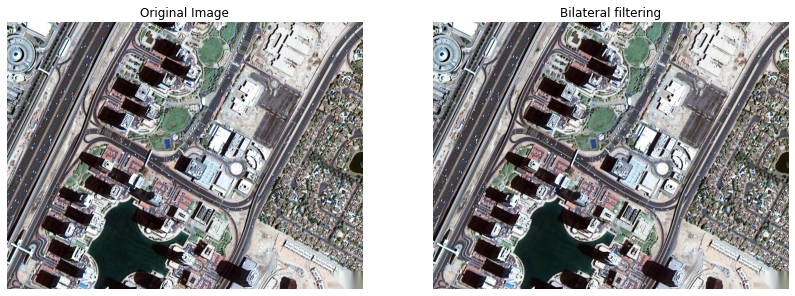

In [20]:
# 显示第一张图片的原图 和 双边滤波后的图片
fig,axs = plt.subplots(1,2,figsize=(14,12))
axs[0].imshow(processing_data1[0])
axs[0].axis('off')
axs[0].set_title("Original Image")
axs[1].imshow(processing_data2[0])
axs[1].axis('off')
axs[1].set_title("Bilateral filtering")
plt.show()

## **Module2**

### **2.1 图像增强**

In [21]:
# 查看原始数据集 形状
display(len(image_data),len(mask_data))

72

72

In [22]:
def add_data_image(data_lists):
  data = []
  for image in data_lists:
    patches_image = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

    for i in range(patches_image.shape[0]):
      for j in range(patches_image.shape[1]):

        single_patch_image = patches_image[i,j,:,:]
        single_patch_image = scaler.fit_transform(single_patch_image.reshape(-1,single_patch_image.shape[-1])).reshape(single_patch_image.shape)
        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
        single_patch_image = single_patch_image[0] #Drop the extra unecessary dimension that patchify adds.
        data.append(single_patch_image)
  return data

In [23]:
def add_data_masks(data_lists):
  data = []
  for image in data_lists:
    patches_mask = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
      for j in range(patches_mask.shape[1]):

        single_patch_mask = patches_mask[i,j,:,:]

        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
        data.append(single_patch_mask)
  return data

In [24]:
image_dataset = add_data_image(image_data)
masks_dataset = add_data_masks(mask_data)

In [25]:
# 查看切割后数据集 形状
display(len(image_dataset),len(masks_dataset))

1305

1305

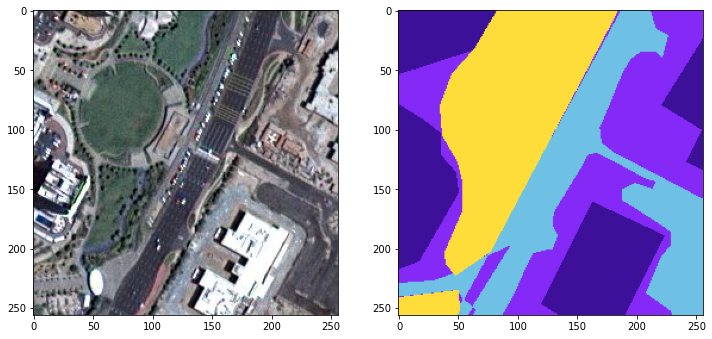

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[2])
plt.subplot(122)
plt.imshow(masks_dataset[2])
plt.show()

In [27]:
# 定义图片保存函数
def images_save(images,types,save_paths):
  os.makedirs(save_paths,exist_ok=True)
  for i,image in enumerate(images):
    save_path = os.path.join(save_paths ,types, f"{types}_{i}.jpg")
    cv2.imwrite(save_path,image * 255)
  print("保存成功！")

In [28]:
images_save(image_dataset,'train','module2/splitdata')
images_save(masks_dataset,'masks','module2/splitdata')

保存成功！
保存成功！


In [29]:
masks_dataset[0].shape

(256, 256, 3)

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [31]:
# 设置要保存的batch数量
num_batches_to_save = 2

#假设扩充合并的图像
# Convert combined images to PIL format
def numpy_to_pil(images):
    pil_images = [Image.fromarray((img * 255).astype(np.uint8)) for img in images]
    return pil_images

combined_pil_images = numpy_to_pil(image_dataset)
combined_pil_masks = numpy_to_pil(masks_dataset)


# Set up data augmentation
datagen = ImageDataGenerator(
        horizontal_flip=True
    )

In [32]:
# Define save directory for augmented images
image_save_dir = 'module2/result/images'
mask_save_dir = 'module2/result/masks'

os.makedirs(image_save_dir, exist_ok=True)
os.makedirs(mask_save_dir, exist_ok=True)

for i, image in enumerate(combined_pil_images):
        image_array = np.array(image) / 255.0
        image_array = np.expand_dims(image_array, axis=0)

        generator = datagen.flow(image_array, batch_size=1)
        for batch_index in range(num_batches_to_save):
            augmented_image = generator.next()[0]
            augmented_pil_image = Image.fromarray((augmented_image * 255).astype(np.uint8))
            if augmented_pil_image.mode != 'RGB':
                augmented_pil_image = augmented_pil_image.convert('RGB')
            save_path = os.path.join(image_save_dir, f'image_{i}_{batch_index}.jpg')
            augmented_pil_image.save(save_path)
print("images 保存成功")
for i, image in enumerate(combined_pil_masks):
        image_array = np.array(image) / 255.0
        image_array = np.expand_dims(image_array, axis=0)

        generator = datagen.flow(image_array, batch_size=1)
        for batch_index in range(num_batches_to_save):
            augmented_image = generator.next()[0]
            augmented_pil_image = Image.fromarray((augmented_image * 255).astype(np.uint8))
            if augmented_pil_image.mode != 'RGB':
                augmented_pil_image = augmented_pil_image.convert('RGB')
            save_path = os.path.join(mask_save_dir, f'mask_{i}_{batch_index}.jpg')
            augmented_pil_image.save(save_path)
print("masks 保存成功")

images 保存成功
masks 保存成功


### **2.2 无监督图形分割**

#### **2.2.1 肘部法则**

In [33]:
import random
from sklearn.cluster import KMeans

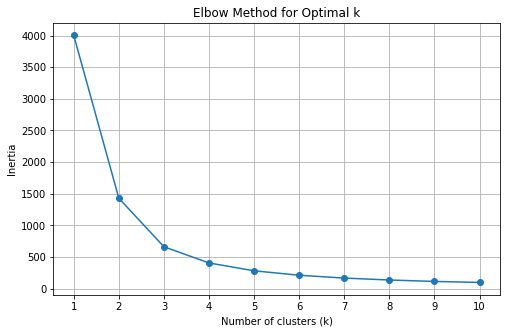

In [34]:
# 计算不同聚类数量的K-means
inertia = []
k_values = range(1, 11)

# 随机选取一张图片 进行评估
num = random.randint(0,len(image_dataset) ) # 这个地方可能会出错，越界
pixels = image_dataset[num].reshape(-1, image_dataset[num].shape[-1])  # Flatten image

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(pixels)
    inertia.append(kmeans.inertia_)

# 绘制肘部法则图
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

#### **2.2.2 构建模型**

In [35]:
# 由上图可知 n_clusters 最好为3
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans

KMeans(n_clusters=3, random_state=0)

In [36]:
def perform_kmeans_clustering_on_images(kmeans, images):
    kmeans_results = []
    for i,img in enumerate(images):
      pixels = img.reshape(-1, img.shape[-1])  # Flatten image
      kmeans_labels = kmeans.fit_predict(pixels)
      # kmeans_labels = kmeans.predict(pixels)
      kmeans_labels = kmeans_labels.reshape(img.shape[0], img.shape[1])
      kmeans_results.append(kmeans_labels)
      print(f"图片{i}处理成功")
    return kmeans_results

In [37]:
# segmentation_output_dir = 'dataset/module2/output'
kmeans_results = perform_kmeans_clustering_on_images(kmeans,image_dataset[:10])

图片0处理成功
图片1处理成功
图片2处理成功
图片3处理成功
图片4处理成功
图片5处理成功
图片6处理成功
图片7处理成功
图片8处理成功
图片9处理成功


#### **2.2.3 识别农田**

In [38]:
patch_size =  256
# 获取聚类的第一张图片
images_kmeans = kmeans_results[0]

# 将标签重新整形为原始图像的形状
labels_image = images_kmeans.reshape(patch_size, patch_size)

In [39]:
# 假设 农田 类别 为 1
classes = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


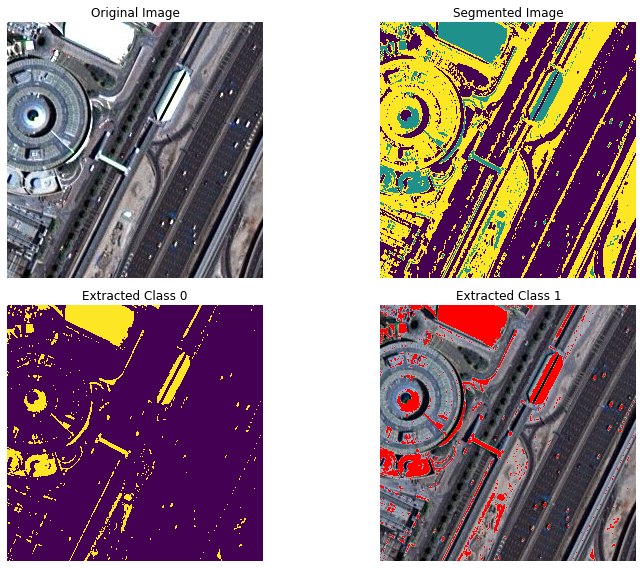

In [40]:
# 绘制图像
plt.figure(figsize=(12, 8))

# 显示 原始 图片
plt.subplot(2, 2, 1)
plt.imshow(image_dataset[0])
plt.title('Original Image')
plt.axis('off')

# 显示 分组 图片
plt.subplot(2, 2, 2)
plt.imshow(labels_image)
plt.title('Segmented Image')
plt.axis('off')

# 显示 类别 图片
farmland_mask = (labels_image == classes)
plt.subplot(2, 2, 3)
plt.imshow(farmland_mask)
plt.title('Extracted Class 0')
plt.axis('off')

# 在原图上显示类别1
colored_image = np.copy(image_dataset[0])
colored_image[labels_image == classes] = [255, 0, 0]  # 红色
plt.subplot(2, 2, 4)
plt.imshow(colored_image)
plt.title('Extracted Class 1')
plt.axis('off')

plt.tight_layout()
plt.show()

## **Module3**

#### **3.1 数据处理**

In [41]:
palette = {0:(60,16,152),
      1:(132,41,246),
      2:(110,193,228),
      3:(254,221,58),
      4:(226,169,41),
      5:(155,155,155)
      }
invert_palette = {v:k for k,v in palette.items()}

In [42]:
def convert_to_color(arr_2d,palette=palette):
  arr_3d = np.zeros((arr_2d.shape[0],arr_2d.shape[1],3),dtype=np.uint8)
  for c,i in palette.items():
    m = arr_2d==c
    arr_3d[m]=i
  return arr_3d

In [43]:
def convert_from_color(arr_3d, palette=invert_palette):
  arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)
  min_distance = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.float32)+1000
  for c, i in palette.items():
    distance = np.sum((arr_3d - np.array(c).reshape(1, 1, 3))**2, axis=-1)**(1/2)
    condition = min_distance > distance
    min_distance[condition] = distance[condition]
    arr_2d[condition] = i

  for c, i in palette.items():
    m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
    arr_2d[m] = i
  arr_2d = arr_2d.tolist()

  for i in range(len(arr_2d)):
    for j in range(len(arr_2d[0])):
      label = [0, 0,0,0,0,0]
      label[arr_2d[i][j]] = 1
      arr_2d[i][j] = label
  arr_2d = np.array(arr_2d)
  return arr_2d

In [44]:
image_dataset = np.asarray(image_dataset)
masks_dataset = np.asarray(masks_dataset)
#X_test.shape

In [45]:
X_train = image_dataset / 255
Y_train_label=[]
for i in range(len(masks_dataset)):
  Y_train_label.append(convert_from_color(masks_dataset[i][:,:,:3]))
Y_train_label = np.array(Y_train_label)

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train_label, test_size = 0.20, random_state = 42)

### **3.2 模型构建**

#### 3.2.1 构建基础模型

In [47]:
from keras import Input
from keras import layers,Model

inputs = Input(shape=(256,256,3))
conv1 = layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same')(inputs)
conv1 = layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same')(conv1)

pool1 = layers.MaxPooling2D(pool_size=2)(conv1)
conv2 = layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(pool1)
conv2 = layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(conv2)

pool2 = layers.MaxPooling2D(pool_size=2)(conv2)
conv3 = layers.Conv2D(filters=128,kernel_size=3,activation='relu',padding='same')(pool2)
conv3 = layers.Conv2D(filters=128,kernel_size=3,activation='relu',padding='same')(conv3)

up1 = layers.UpSampling2D(size=(2,2))(conv3)
merge1 = layers.concatenate([conv2, up1],axis=3)
conv4 = layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(merge1)
conv4 = layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(conv4)

up2 = layers.UpSampling2D(size=(2,2))(conv4)
merge2 = layers.concatenate([conv1, up2],axis=3)
conv5 = layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same')(merge2)
conv5 = layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same')(conv5)

conv6 = layers.Conv2D(filters=6,kernel_size=3,activation='softmax',padding='same')(conv5)

model1 = Model(inputs=inputs, outputs=conv6)

In [48]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [49]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [50]:
# model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model1.compile(optimizer='adam',loss=sm.losses.categorical_focal_jaccard_loss,metrics=[sm.metrics.iou_score])

In [51]:
y_train = y_train.astype(np.float64)  # 转换标签数据类型

In [ ]:
history1 = model1.fit(X_train,y_train,batch_size=10,epochs=80)

In [53]:
y_test = y_test.astype(np.float64)

In [54]:
loss, iou_score = model1.evaluate(X_test, y_test, verbose=1)
print(f"Average LOSS: {loss:.4f}")
print(f"Average IOU: {iou_score:.4f}")

9/9 [==============================] - 3s 151ms/step - loss: 0.4754 - iou_score: 0.5459
Average LOSS: 0.4754
Average IOU: 0.5459


In [55]:
# 保存模型
model1.save('history1.hdf5')

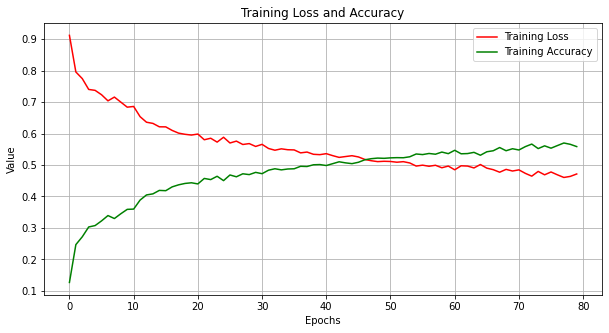

In [56]:
import matplotlib.pyplot as plt

# 绘制loss和accuracy的折线图
plt.figure(figsize=(10, 5))  # 设置图形的大小

# 绘制loss曲线
plt.plot(history1.history['loss'], label='Training Loss', color='r')
# 如果你的模型在验证集上也进行了评估，你还可以绘制验证loss
# plt.plot(history.history['val_loss'], label='Validation Loss', color='b')

# 绘制accuracy曲线
plt.plot(history1.history['iou_score'], label='Training Accuracy', color='g')
# 同样，如果进行了验证，你也可以绘制验证accuracy
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='purple')

# 添加图例
plt.legend()

# 设置x轴和y轴的标签
plt.xlabel('Epochs')
plt.ylabel('Value')

# 添加标题
plt.title('Training Loss and Accuracy')

# 显示网格
plt.grid(True)

# 显示图形
plt.show()

#### 3.2.2 构建复合模型

In [57]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [58]:
image_dataset[0].shape

(256, 256, 3)

In [59]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [60]:
n_classes=6
model2 = sm.Unet(BACKBONE, encoder_weights='imagenet',
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model2.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

In [61]:
print(X_train.dtype)  # 检查特征数据类型
print(y_train.dtype)  # 检查标签数据类型

float64
float64


In [62]:
y_train = y_train.astype(np.float64)  # 转换标签数据类型

In [ ]:
history2=model2.fit(X_train,y_train,batch_size=10,
          epochs=80,
          verbose=1)

In [64]:
loss, iou_score = model2.evaluate(X_test, y_test, verbose=1)
print(f"Average LOSS: {loss:.4f}")
print(f"Average IOU: {iou_score:.4f}")

9/9 [==============================] - 3s 169ms/step - loss: 0.4284 - iou_score: 0.5972
Average LOSS: 0.4284
Average IOU: 0.5972


In [65]:
# 保存模型
model2.save('history2.hdf5')

/home/ubuntu/dgw/myenv/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


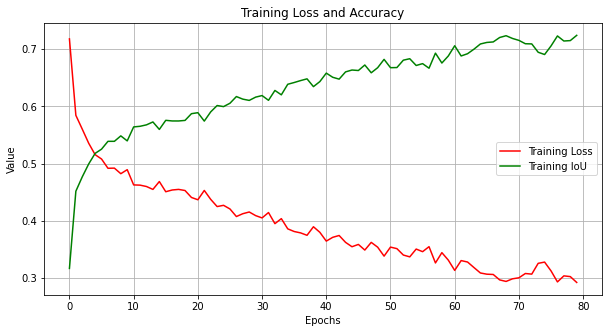

In [66]:
import matplotlib.pyplot as plt


# 绘制loss和accuracy的折线图
plt.figure(figsize=(10, 5))  # 设置图形的大小

# 绘制loss曲线
plt.plot(history2.history['loss'], label='Training Loss', color='r')
# 如果你的模型在验证集上也进行了评估，你还可以绘制验证loss
# plt.plot(history.history['val_loss'], label='Validation Loss', color='b')

# 绘制accuracy曲线
plt.plot(history2.history['iou_score'], label='Training IoU', color='g')
# 同样，如果进行了验证，你也可以绘制验证accuracy
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='purple')

# 添加图例
plt.legend()

# 设置x轴和y轴的标签
plt.xlabel('Epochs')
plt.ylabel('Value')

# 添加标题
plt.title('Training Loss and Accuracy')

# 显示网格
plt.grid(True)

# 显示图形
plt.show()

### **3.3 图像分类**

In [68]:
predictions = model2.predict(X_test, batch_size=1)

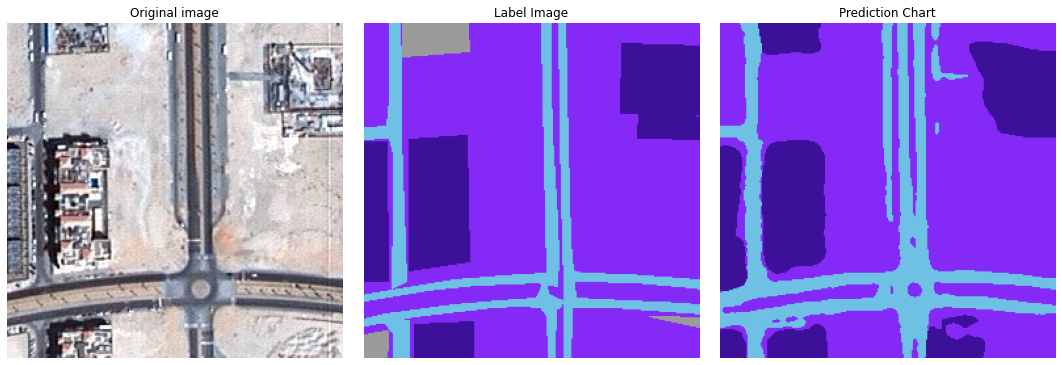

In [69]:
# 展示第一张图片
fig,axs = plt.subplots(1,3,figsize=(15,5))
axs[0].imshow(X_test[0] * 255)
axs[0].set_title("Original image")
axs[0].axis('off')
axs[1].imshow(convert_to_color(np.argmax(y_test[0], axis=-1)))
axs[1].set_title("Label Image")
axs[1].axis('off')
axs[2].imshow(convert_to_color(np.argmax(predictions[0], axis=-1)))
axs[2].set_title("Prediction Chart")
axs[2].axis('off')
plt.tight_layout()
plt.show()

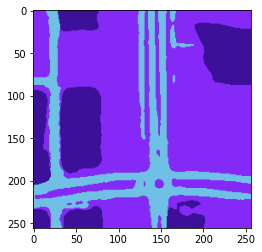

In [70]:
plt.imshow(convert_to_color(np.argmax(predictions[0], axis=-1)))

In [71]:
# 获取第1张图片
image = np.argmax(predictions[0], axis=-1)

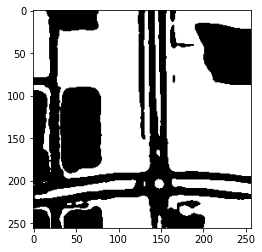

In [82]:
# 获取 类别 2
target_class = 1
extracted_mask = np.zeros((256, 256), dtype=np.uint8)
extracted_mask[image == target_class] = 255
plt.imshow(extracted_mask,cmap='gray')

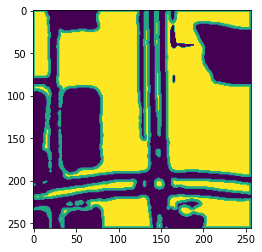

In [83]:
_,contours, hierarchy = cv2.findContours(extracted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 在原始图像上标记区域
for contour in contours:
    """
    cv2.drawContours: 这个函数用于在图像上绘制轮廓。
    image: 要在其上绘制轮廓的原始图像。
    [contour]: 需要绘制的轮廓，作为列表传入。
    -1: 表示绘制所有轮廓。如果指定为特定索引，则只绘制该索引的轮廓。
    (155, 155, 155): 轮廓的颜色，使用 BGR 格式（在此为灰色）。
    2: 轮廓线的厚度。
    """
    cv2.drawContours(extracted_mask, [contour], -1, (155, 155, 155), 2)  # 绘制轮廓
    """
    cv2.putText: 这个函数用于在图像上添加文本。
    image: 要在其上添加文本的图像。
    'Segmented': 要添加的文本内容。
    tuple(contour[0][0]): 文本的位置，使用轮廓的第一个点的坐标作为文本的起始位置。
    cv2.FONT_HERSHEY_SIMPLEX: 字体类型，使用 OpenCV 提供的字体。
    0.5: 字体大小。
    (255, 0, 0): 文本的颜色，使用 BGR 格式（在此为红色）。
    2: 文本的厚度。
    """
    # cv2.putText(extracted_mask, 'Segmented', tuple(contour[0][0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # 添加文本

plt.imshow(extracted_mask)

In [84]:
#